In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['seg_train', 'seg_pred', 'seg_test']


In [2]:
!ls ../input

seg_pred  seg_test  seg_train


In [3]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [4]:
import torch.utils.data as tdata

In [5]:
!ls ../input/seg_train/seg_train/
!ls ../input/seg_test/seg_test/

buildings  forest  glacier  mountain  sea  street
buildings  forest  glacier  mountain  sea  street


In [6]:
data_path_format = '../input/seg_{0}/seg_{0}'

In [7]:
np.random.seed(5315)
torch.manual_seed(9784)

In [8]:
# channel_means = (0.4301, 0.4572, 0.4540)
# channel_stds = (0.2698, 0.2680, 0.2983)  # 0.485, 0.456, 0.406
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [10]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None}


In [11]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [12]:
from sklearn import model_selection

In [13]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [14]:
print(len(val_indices))

1404


In [15]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [16]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'train': <torch.utils.data.dataset.Subset object at 0x7fd6b55d9f60>, 'validation': <torch.utils.data.dataset.Subset object at 0x7fd6b55d9f28>}


In [17]:
from IPython.display import display

In [18]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [19]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [20]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

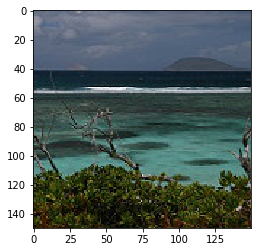

In [21]:
imshow(image_datasets['train'][8555][0]) # 5946

In [22]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [23]:
import torch.nn as nn
import torch.nn as F

class MyModel(nn.Module):
    def conv_layer(self, input_, output_, kernel):
            return nn.Sequential(torch.nn.Conv2d(input_, output_, kernel, padding=1), 
                                 nn.Tanh(),
                                 nn.BatchNorm2d(output_),
                                 nn.MaxPool2d(2,2))
    def conv_layer_dropout(self, input_, output_, kernel):
            return nn.Sequential(torch.nn.Conv2d(input_, output_, kernel, padding=1), 
                                 nn.ReLU(),
                                 nn.Dropout(p = 0.15),
                                 nn.BatchNorm2d(output_),
                                 nn.MaxPool2d(2,2))
        
    def linear_layer_out(self,input_,output_):
            return nn.Sequential(torch.nn.Linear(input_, output_),
                                nn.ReLU())
        
    def linear_layer(self,input_,output_):
            return nn.Sequential(torch.nn.Linear(input_, output_),
                                nn.ReLU(),
                                nn.Dropout(p = 0.15))
    
    def __init__(self):
            #150
            super(MyModel, self).__init__()
            self.conv1 = self.conv_layer(3,12,2)
            self.conv2 = self.conv_layer(12,24,2)
            self.conv3 = self.conv_layer_dropout(24,48,2)
            self.conv4 = self.conv_layer_dropout(48,96,2)
            
            self.fc1 = self.linear_layer(96 * 10 * 10,300)
            self.fc2 = self.linear_layer(300, 150)
            self.fc3 = self.linear_layer_out(150 , 6)

                
    def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            
            #print(x.size(1) , x.size(2) , x.size(3))
            
            x = x.view(x.size(0),x.size(1) * x.size(2) * x.size(3) )
            x = self.fc1(x)
            x = self.fc2(x)
            x = self.fc3(x)
            return x    
ptr = MyModel()
ptr = ptr.to(device)

In [24]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [25]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                

In [26]:
import time
start = time.time()

In [27]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(5, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.0597481012721606
Epoch 0, iteration 315 training_loss 0.7956219853102406
Epoch 0, iteration 473 training_loss 0.6790286270500738
Epoch 0, iteration 631 training_loss 0.6588266311755663
Epoch 0, iteration 789 training_loss 0.6036325345122362
Epoch 0, val_loss 0.525343916463581, accuracy = 0.811965811965812
Epoch 1, iteration 157 training_loss 0.5120954620121401
Epoch 1, iteration 315 training_loss 0.545395145122009
Epoch 1, iteration 473 training_loss 0.48729771394518356
Epoch 1, iteration 631 training_loss 0.5364688252912292
Epoch 1, iteration 789 training_loss 0.4922962767791145
Epoch 1, val_loss 0.40850734439763153, accuracy = 0.8490028490028491
Epoch 2, iteration 157 training_loss 0.4015920242365402
Epoch 2, iteration 315 training_loss 0.4408091680158543
Epoch 2, iteration 473 training_loss 0.3845260048025771
Epoch 2, iteration 631 training_loss 0.3918976053784165
Epoch 2, iteration 789 training_loss 0.43833050424162345
Epoch 2, val_loss 0.5211

In [28]:
end = time.time()
print(end - start)

209.47487831115723


In [29]:
from torchvision.utils import make_grid

In [30]:
xx, yy = next(iter(image_dataloaders['validation']))

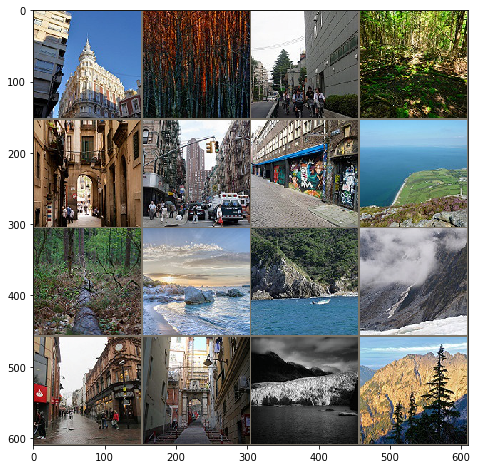

['buildings', 'forest', 'buildings', 'forest', 'street', 'street', 'street', 'sea', 'forest', 'sea', 'sea', 'glacier', 'street', 'street', 'glacier', 'mountain']
['buildings', 'forest', 'street', 'forest', 'buildings', 'street', 'street', 'sea', 'forest', 'sea', 'sea', 'glacier', 'street', 'street', 'glacier', 'mountain']


In [31]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [32]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [33]:
from sklearn import metrics

In [34]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [35]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.83      0.84      0.83       437
      forest       0.86      0.97      0.91       474
     glacier       0.82      0.78      0.80       553
    mountain       0.80      0.82      0.81       525
         sea       0.85      0.87      0.86       510
      street       0.91      0.78      0.84       501

   micro avg       0.84      0.84      0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [36]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,368,19,5,4,12,29
forest,2,462,2,4,2,2
glacier,2,11,432,74,29,5
mountain,2,6,61,428,28,0
sea,10,7,22,22,446,3
street,62,33,7,4,6,389


# 1.3

In [37]:
def grad(x,y):
    x = x.clone()
    y = y.clone()
    x.requires_grad_(True)
    f = 1 / (1 + torch.exp(-torch.dot(x,y)))
    f.backward()
    return x.grad
x = torch.tensor([1.,5.,-3.,4.])
y = torch.tensor([-2.,-6.,4.,-5.])
grad(x,y)


tensor([-0., -0., 0., -0.])